In [13]:
import numpy as np
import scipy.io as sio
from scipy.linalg import toeplitz
from scipy.stats import multivariate_normal
import time
import random
from scipy.linalg import block_diag
from sklearn.metrics import precision_recall_curve, auc
import scipy.stats
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import random
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle


import sys
# sys.path.append('/Users/yijwang-admin/Documents/Research/GFL/Code/PQN_Python_main')
from minConf.minConf_PQN import minConF_PQN
import random

# Section 1: Data Generation

Here we generate data for random ensemble I.

To generate the synthetic data, we need to generate the following: the design matrix $X$, the graph (there are several equivalent way to record the information, adjacent matrix $A$, Laplacian $L$, etc.), the weight $w$, and the response vector $y$.

Given the sample size $n$, the number of features $d$, the random design matrix $X \in \mathbb{R}^{n \times d} $ is generated with i.i.d. $ \mathcal{N}(0, 1) $ entries. 

Given the number of selected features $k$, without loss of generality (by symmetry and permutation), we choose the first $k$ as the selected features. i.e. non-zero features contributing to the target. We randomly partition this $k$ features into $h'$ clusters with size $c_1, c_2, \dots, c_{h'}$. We also randomly partition the rest features into $h''$ clusters with size $c_{h'+1}, c_{h'+2}, \dots, c_{h'+h''}$. Obviously, we have $c_1 + \dots + c_{h'} = k$  and $c_{h'+1}+ \dots c_{h'+h''}= d-k$. We denote the total number of the clusters by $h  = h' + h''$.

We construct the regression weight vector \( w \in \mathbb{R}^d \) such that non-zero coefficients only appears for the selected feature. For features in the same cluster, the corresponding coefficients in $w$ are set to be the same. We randomly assign them from one of the value $\pm \frac{1}{\sqrt{k}}$. 

The next step is to generate the graph which is compatible with the cluster structure with some noise. Fix two probability parameters $p > \frac{1}{2}$ and $q < \frac{1}{2}$, which indicates that probability of edges connecting two feature nodes in a same cluster and probability of edges connecting two feature nodes in different cluster, respectively. It reflect that there are some edge missing and some noisy edges in the real world prior graphical knowledge. In other words, we generate the graph by connecting two nodes in a same cluster with probability $p$ and connecting two nodes in different cluster with probability $q$.

Finally, we define the response vector \( y = X w + \epsilon \), where the noise vector \( \epsilon \in \mathbb{R}^n \) has i.i.d. \( \mathcal{N}(0, \gamma^2) \) entries. The goal is to identify the support of \( w \) and the corresponding coefficients. This simulation design allows us to examine whether the method can recover (the cluster structure) and individual feature sparsity under this random ensemble.

We need following parameters to determine a random ensemble:
- `n`: the number of samples
- `d`: the number of features
- `k`: the number of selected features
- `h_total`: the number of clusters
- `h_selected`: the number of clusters for the selected features
- `h_rest`: the number of clusters for the rest features
- `gamma`: the noise level
- `p`: the probability of edges connecting two feature nodes in a same cluster
- `q`: the probability of edges connecting two feature nodes in different cluster

## Section 1.1 Graph Generation

In [58]:
class RandomEnsemble:
    def __init__(self, n, d, k, h_total, h_selected, h_rest, gamma, p=0.95, q=0.01):
        assert h_total == h_selected + h_rest, "h_total should be equal to h_selected + h_rest"
        self.n = n
        self.d = d
        self.k = k
        self.h_total = h_total
        self.h_selected = h_selected
        self.h_rest = h_rest
        self.gamma = gamma
        self.p = p
        self.q = q

    def _random_partition(self):
        # partition the first k nodes into h_selected groups and the rest into h_rest groups
        assert self.h_selected <= self.k, "h_selected should be less than k"
        assert self.h_rest <= self.d - self.k, "h_rest should be less d-k"
        break_points = np.sort(random.sample(range(1, self.k), self.h_selected-1))
        break_points_rest = np.sort(random.sample(range(self.k+1, self.d), self.h_rest-1))

        return break_points, break_points_rest
    
    def _generate_clusters(self):
        break_points, break_points_rest = self._random_partition()
        clusters = []
        clusters.append(np.arange(break_points[0])) # first selected cluster
        for i in range(1, self.h_selected-1):
            clusters.append(np.arange(break_points[i-1], break_points[i]))
        clusters.append(np.arange(break_points[-1], self.k)) # last selected cluster

        clusters.append(np.arange(self.k, break_points_rest[0])) # first rest cluster
        for i in range(1, self.h_rest-1):
            clusters.append(np.arange(break_points_rest[i-1], break_points_rest[i]))
        clusters.append(np.arange(break_points_rest[-1], self.d))

        return clusters

    def _generate_graph(self):
        # here we generate the adjacency matrix and laplacian of the graph
        clusters = self._generate_clusters()

        A = sp.lil_matrix((self.d, self.d), dtype=int)
        
        # generate thr inner cluster connections
        for cluster in clusters:
            cluster_size = len(cluster)
            block = (np.random.rand(cluster_size, cluster_size) < self.p).astype(int)
            np.fill_diagonal(block, 0) # no self-loop
            block = np.triu(block) + np.triu(block, 1).T # make it symmetric
            for i, node_i in enumerate(cluster):
                for j, node_j in enumerate(cluster):
                    A[node_i, node_j] = block[i, j]

        # generate the connections between clusters
        for i in range(self.h_total):
            for j in range(i+1, self.h_total):
                cluster_i = clusters[i]
                cluster_j = clusters[j]
                block = (np.random.rand(len(cluster_i), len(cluster_j)) < self.q).astype(int)
                for m, node_i in enumerate(cluster_i):
                    for n, node_j in enumerate(cluster_j):
                        A[node_i, node_j] = block[m, n]
                        A[node_j, node_i] = block[m, n]

        # TODO: check if the graph is connected and make it connected if not 
        # (optional, maybe not necessary)
        return A, clusters
    
    def _visualize_graph(self, A):
        # if we want to visualize the graph, we need to change it to array rather than sparse matrix
        A_arr = A.toarray()
        plt.figure(figsize=(8, 8))
        plt.title('Adjacency matrix')
        plt.spy(A_arr)
        plt.axis('off')
        plt.show()

    def _generate_w(self, clusters):
        w = np.zeros(self.d) 
        for i in range(self.h_selected):
            cluster_sign = np.random.choice([-1, 1])
            cluster_weight = cluster_sign * (1 / np.sqrt(self.k)) # TODO: make more choice other than 1/sqrt(k)
            for node in clusters[i]:
                w[node] = cluster_weight
        return w

    def _generate_X(self):
        X = np.random.normal(0, 1, (self.n, self.d))
        return X
    
    def _generate_y(self, X, w):
        noise = np.random.normal(0, self.gamma, self.n)
        signal = X @ w
        y = signal + noise
        SNR = self._compute_snr(signal, noise)
        if 0: # TODO: add a debug/verbose flag
            print(f'SNR: {SNR}')

        return y

    def _generate_data(self):
        A, clusters = self._generate_graph()
        if 0: # TODO: add a debug/verbose flag 
            self._visualize_graph(A)
        w = self._generate_w(clusters)
        X = self._generate_X()
        y = self._generate_y(X, w)
        return A, w, X, y


    def _compute_snr(self, signal, noise):  
        # in our case, the snr is 10*log10(1/gamma^2)
        signal = np.asarray(signal)
        noise = np.asarray(noise)

        signal_power = np.mean(signal ** 2)
        noise_power = np.mean(noise ** 2)
        
        snr = signal_power / noise_power
        snr_db = 10 * np.log10(snr)
        
        return snr_db
    
    def _define_obj(self, model):
        """
        Support models: 'Lasso', GroupLasso', 'GeneralizedFusedLasso'
        I plan to support Proximal method by calling matlab session
        this part and the one below is to support PQN, the Proxiaml method is on its own, it does not need this
        """
        if model == "Lasso":
            return lambda u: Lasso(u, self.X, self.y, self.rho)
        elif model == "GroupLasso":
            return lambda u: GroupLasso(u, self.X, self.y, self.rho, self.groups)
        elif model == "GeneralizedFusedLasso":
            return lambda u: GeneralizedFusedLasso(u, self.X, self.y, self.rho, self.A)
        else:
            raise ValueError("Model not supported")
        
    def _define_projectopm(self, model):
        """
        Support models: 'Lasso', GroupLasso', 'GeneralizedFusedLasso'
        """
        


    def solve(self, model):

    def cross_validation(self, model):
        pass

    def evaluate(self, model):
        pass
        
    
        


In [ ]:
import numpy as np
from scipy.sparse import spdiags
from scipy.linalg import inv
from gurobipy import Model, GRB, QuadExpr

def Lasso(u, X, y, rho):
    n, d = X.shape
    D_u = spdiags(u.flatten(), 0, d, d)
    M = inv((1/rho) * X @ D_u @ X.T + np.eye(n))
    f = y.T @ M @ y
    g = -(1/rho) * ((X.T @ M @ y)**2)

    return f, g

def GroupLasso(u, X, y, rho, groups):
    n, d = X.shape
    D_u = spdiags(u.flatten(), 0, d, d)
    M = inv((1/rho) * X @ D_u @ X.T + np.eye(n))
    f = y.T @ M @ y
    g = -(1/(2*rho)) * ((X.T @ M @ y)**2)

    return f, g

def GeneralizedFusedLasso(u, X, y, rho, L, mu):
    n, d = X.shape
    D_u = spdiags(u.flatten(), 0, d, d)
    M = inv((1/rho) * X @ D_u @ X.T + np.eye(n))
    f = y.T @ M @ y + mu * u.T @ L @ u
    g = -(1/(2* rho)) * ((X.T @ M @ y)**2) + 2 * mu * L @ u

    return f, g


def ProjLassoGurobi():


def ProjGroupLassoGurobi():


def ProjGeneralizedFusedLassoGurobi(u, k):
    d, _ = u.shape
    A = np.ones((1, d))
    b = np.array([k])
    Q = np.eye(d)
    f = -2 * u.flatten()

    model = Model("GeneralizedFusedLasso")
    x = model.addMVar(d, lb=0.0, ub=1.0)

    model.setObjective(x@Q@x + x@f)
    model.addConstr(A @ x == b)

    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    model.optimize()

    return x.x







In [64]:
a = randon_ensemble_i(500, 1000, 20, 24, 4, 20, np.sqrt(0.25))
a._generate_data()

SNR: 5.7375100243164


(<1000x1000 sparse matrix of type '<class 'numpy.int64'>'
 	with 112704 stored elements in List of Lists format>,
 array([ 0.2236068,  0.2236068,  0.2236068,  0.2236068,  0.2236068,
         0.2236068,  0.2236068,  0.2236068,  0.2236068,  0.2236068,
         0.2236068,  0.2236068,  0.2236068,  0.2236068,  0.2236068,
        -0.2236068, -0.2236068, -0.2236068,  0.2236068,  0.2236068,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
  

[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


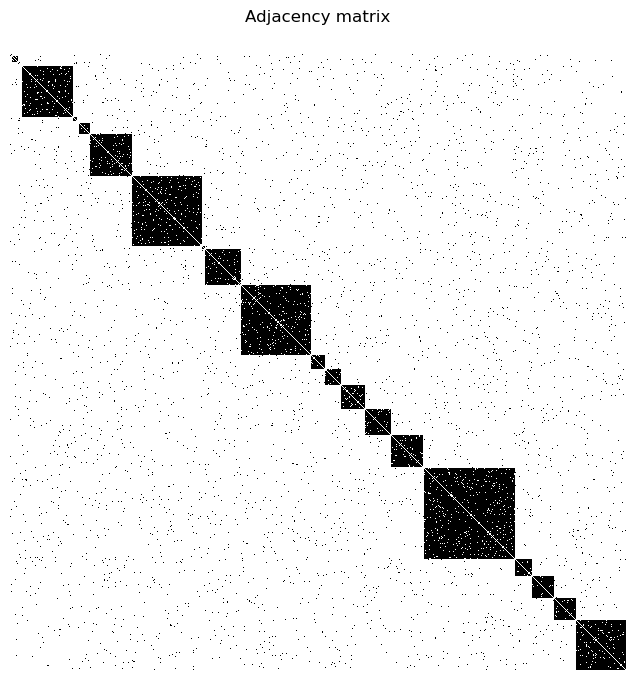

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]])

In [45]:
A_arr = A.toarray()
print(A_arr)
a._visualize_graph(A_arr)

In [ ]:
def add_noise_to_signal(signal, desired_snr_db):
    # Convert signal to numpy array
    signal = np.asarray(signal)
    # Calculate signal power
    signal_power = np.mean(signal ** 2)
    # Calculate the desired noise power based on the desired SNR (in dB)
    desired_snr_linear = 10 ** (desired_snr_db / 10)
    noise_power = signal_power / desired_snr_linear
    # Generate noise with the calculated power
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    # Add noise to the original signal
    noisy_signal = signal + noise
    return noisy_signal, noise
 
 
def compute_snr(signal, noise):
    # Convert signal and noise to numpy arrays for calculations
    signal = np.asarray(signal)
    noise = np.asarray(noise)
 
    # Calculate the power of the signal and the noise
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    # Calculate the SNR
    snr = signal_power / noise_power
    # Convert SNR to decibels (dB)
    snr_db = 10 * np.log10(snr)
    return snr_db

def compute_snr(signal, noise):
    # Convert signal and noise to numpy arrays for calculations
    signal = np.asarray(signal)
    noise = np.asarray(noise)

    # Calculate the power of the signal and the noise
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    
    # Calculate the SNR
    snr = signal_power / noise_power
    
    # Convert SNR to decibels (dB)
    snr_db = 10 * np.log10(snr)
    
    return snr_db



In [62]:
10 * np.log10(1/(0.25))

6.020599913279624

# Section 2: Model Optimization

Here we include the all method for the optimization problem. We will use the following optimization methods to solve the problem:
- Lasso
- NeuIPS 2021
- Fast GFL AAAI-2014
- Our method: Boolean GFL

# Section 3: Experiments

Here we do the experiments: fixed the random ensemble parameters, we generate the data and run the optimization methods. We compare the performance of the methods by the top-k support recovery accuracy and out-of-sample MSE.

We will start with small sample size and increase the sample size with other fixed parameters. For each parameter, we will generate 100 random ensemble and report the average performance in the end. For method with hyperparameters, we use cross-validation to select the best hyperparameters.

# Section 4: Plot

Here we plot the result with respect to the sample size. The error bar means 95% confidence interval.